## CIVENG 263H - Final Project Code
### K-Means Analysis
#### Deadline: 12/13/2023
#### Team: Erin Jones, Breitling Snyder, Jon Atkins, Balaji Balagesenan

In [7]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

### Import Data

In [26]:
# Import cleaned and scaled data
data_w_fips = pd.read_csv('./data/scaled_df.csv')

# Drop numerical fips column or arhcetypes will include this dimension -- future work, it might be interesting to see if states cluster as this is a numerical representation of that to some degree
data_wo_fips = data_w_fips.drop(columns='fips5')

# Create an array -- aa package does not accept df
D = data_wo_fips.to_numpy()

In [27]:
data_w_fips.columns

Index(['dr_str_per_node', 'dr_circuity', 'dr_self_loop', 'dr_str_density',
       'dr_clean_int_density', 'dr_avg_cluster', 'bk_str_per_node',
       'bk_circuity', 'bk_self_loop', 'bk_str_density', 'bk_clean_int_desnity',
       'bk_avg_cluster', 'bk_dr_ratio', 'total_pop', 'pop_density',
       'pop_white', 'pop_black', 'pop_latin', 'edu_bachelor',
       'hh_income_median', 'rent_burden_median', 'two_plus_units', 'renters',
       'under_18', 'cmute_drive', 'cmute_carpool', 'cmute_transit',
       'cmute_travel_time', 'cmute_work_in_county', 'no_vehicle',
       'n_vehicle_avail', 'area_sqkm', 'kgco2_sum', 'emissions_per_cap',
       'fips5'],
      dtype='object')

### Scree ('Elbow') Plot

Starting similar to the archetypal analysis, we are going to run k-means and see what the optimal number of clusters is.

In [9]:
wcss = []
for i in range(1,19):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(D)
    wcss.append(kmeans.inertia_)

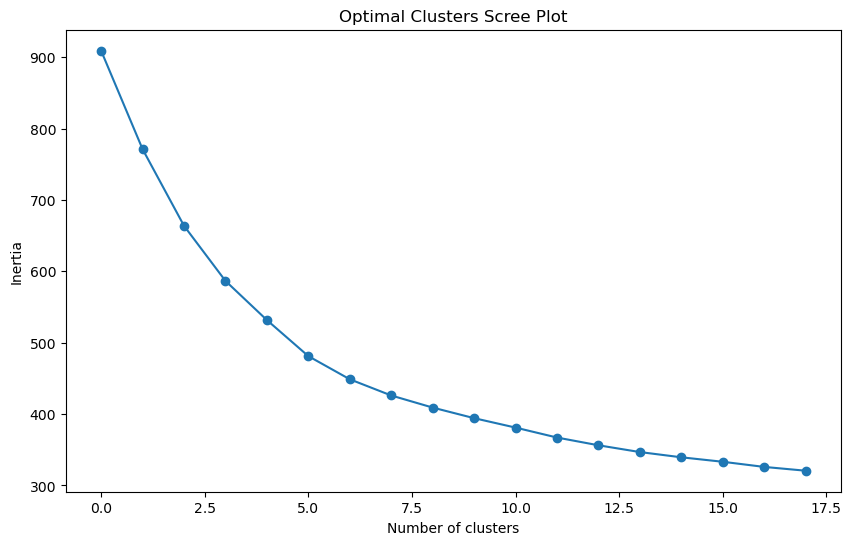

In [10]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(wcss, marker='o')
plt.title('Optimal Clusters Scree Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

This plot is even less angular than that we saw with archetypal analysis, so I am going to run it with the same number of clusters and visualize the characteristics of the clusters

In [11]:
# Applying KMeans
kmeans = KMeans(n_clusters=6, n_init=10)
kmeans.fit(D)

# build DF of resulting cluster centroids
centroids_df_6 = pd.DataFrame(kmeans.cluster_centers_, columns=data_wo_fips.columns)

### Plotting Formulae 

The below to formula help to improve the ease of plotting the centroid characteristics

In [14]:
def plot_vertical_kmeans_bar(centroids_df):
    # melt df for plotting
    centroids_df['Cluster'] = centroids_df.index
    melted = centroids_df.melt(id_vars='Cluster', var_name='Feature', value_name='Value')
    melted['Value'] = melted['Value'].astype(float)
    # plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Cluster', y='Value', hue='Feature', data=melted)
    plt.title('Cluster Makeup')
    plt.legend(loc='best')
    return plt.show()

def plot_horizontal_kmeans_bar(centroids_df, n_clusters):
    # melt df for plotting
    centroids_df['Cluster'] = centroids_df.index
    melted = centroids_df.melt(id_vars='Cluster', var_name='Feature', value_name='Value')
    melted['Value'] = melted['Value'].astype(float)

    # subset df by cluster + add to dict
    subset_dict = {}
    for i in range(n_clusters):
        subset_dict[i] = melted[melted['Cluster'] == i] 

    # Creating a figure with 3 subplots
    fig, axs = plt.subplots(n_clusters, 1, figsize=((12*n_clusters), 50))

    color_list = ['brown', 'coral', 'gold', 'olivedrab', 'mediumseagreen', 'darkturquoise', 'plum']

    for n_cluster, subset in subset_dict.items():
        axs[n_cluster].bar(subset['Feature'], subset['Value'], color = color_list[n_cluster])
        axs[n_cluster].set_title(f'Cluster {n_cluster}', fontsize=30)
        axs[n_cluster].tick_params(axis='x', labelsize=25, rotation=30)
        axs[n_cluster].tick_params(axis='y', labelsize=20)


    plt.tight_layout()
    return plt.show()

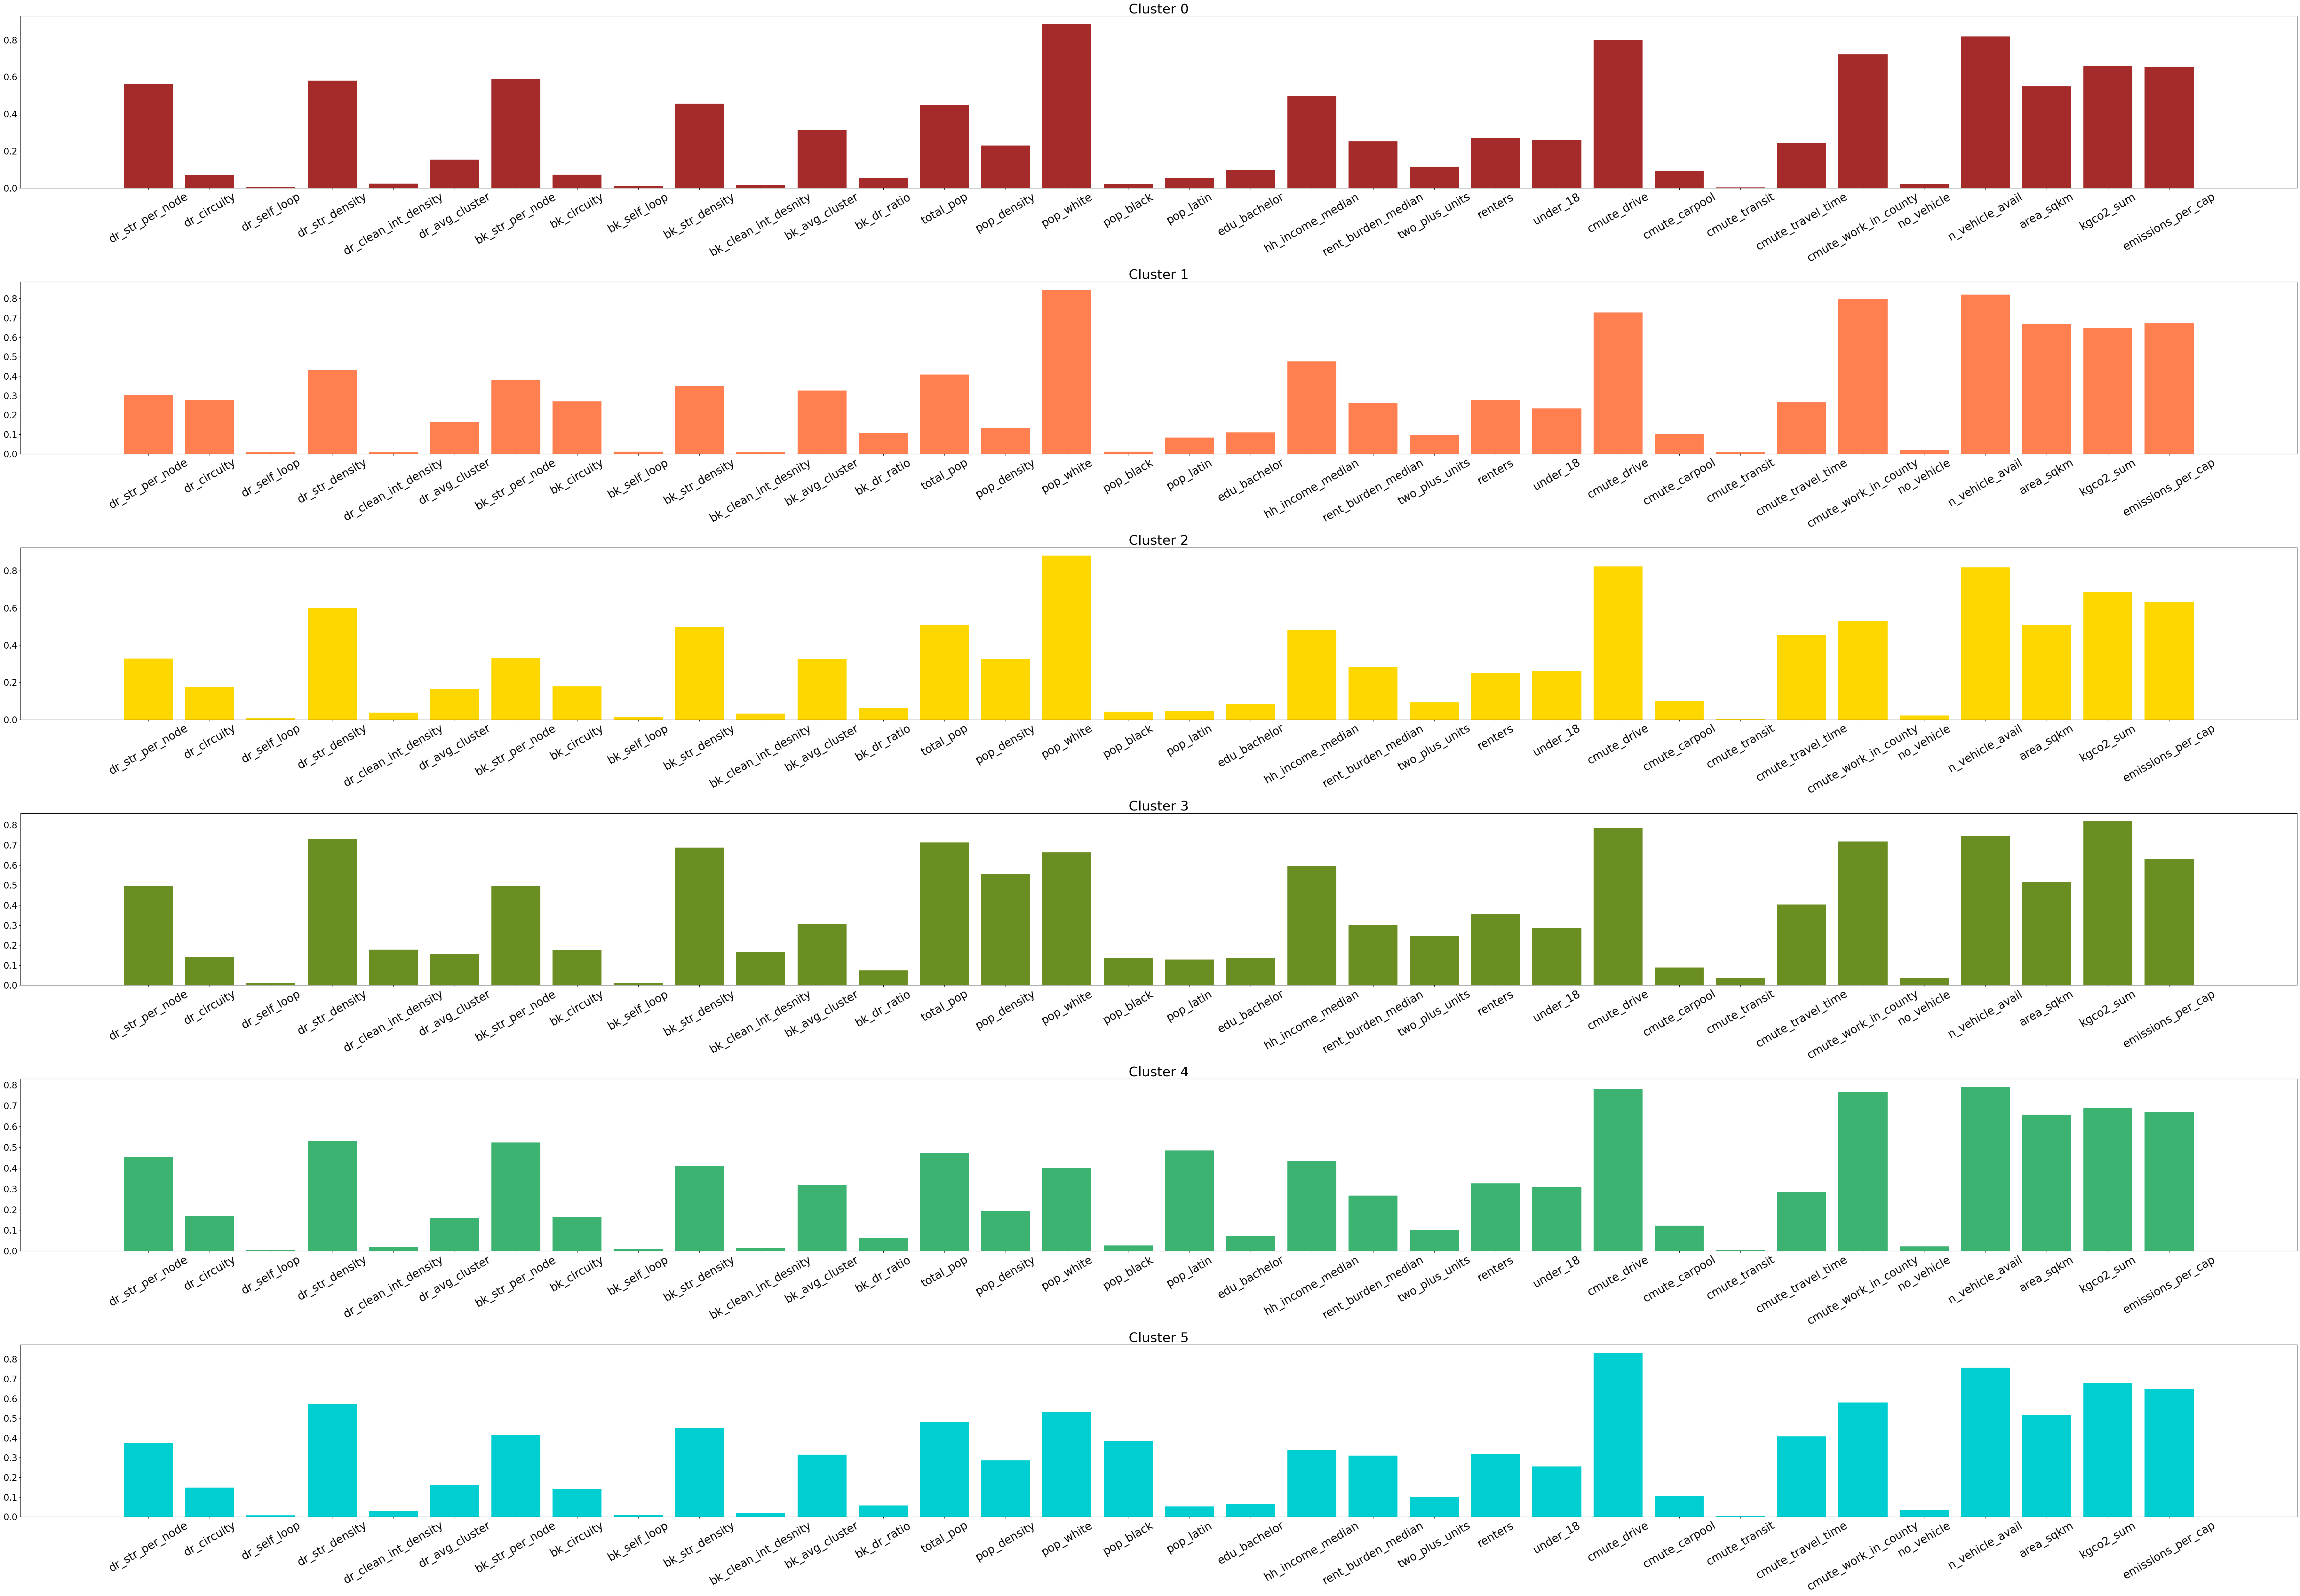

In [15]:
plot_horizontal_kmeans_bar(centroids_df_6, 6)

The variance across characteristic featues is less when comparing this to the initial archetypes plot produced in the first analysis, which makes sense given that these are describing the centers and the archetypes are describing the means. As such it is harder to pick features that have big variance for the purposes of this clustering analysis. The only ones I can identify above are the following features:

* dr_str_per_node
* dr_circuity
* dr_clean_int_density
* bk_circuity
* bk_clean_int_density
* bk_dr_ratio
* pop_density
* pop_white
* pop_black
* pop_latin
* cmute_transit
* kgco2_sum

It is interesting because these are quite different from those that fell out in archetypal analysis

In [16]:
reduced_data = data_wo_fips.loc[:,['dr_str_per_node', 
                                    'dr_circuity',
                                    'dr_clean_int_density',
                                    'bk_circuity',
                                    'bk_clean_int_desnity',
                                    'bk_dr_ratio', 
                                    'pop_density',
                                    'pop_white',
                                    'pop_black',
                                    'pop_latin',
                                    'cmute_transit',
                                    'kgco2_sum']]

D_r = reduced_data.to_numpy()

### Scree 2

The one beautiful thing I recognize when running this algorithm is that it is beautifully fast - it runs so much faster than archetypes when you get into large numbers of archetypes

In [17]:
wcss = []
for i in range(1,19):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(D_r)
    wcss.append(kmeans.inertia_)

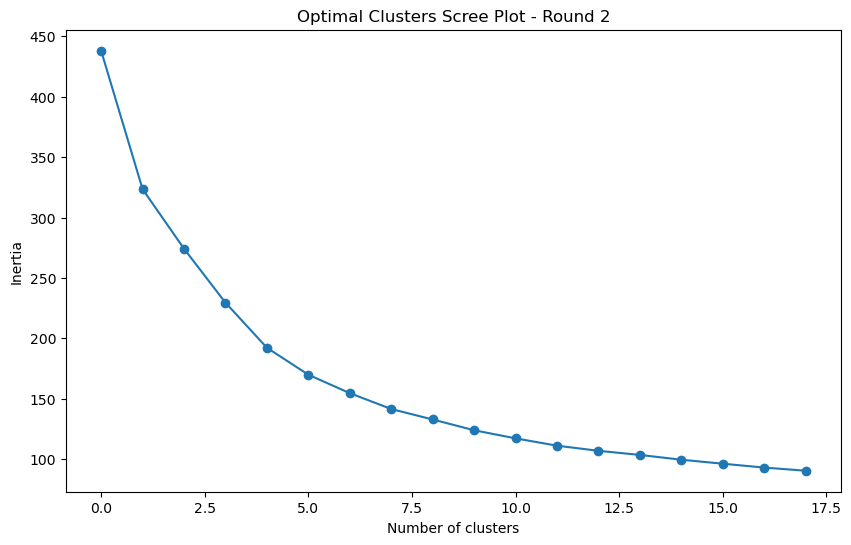

In [18]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(wcss, marker='o')
plt.title('Optimal Clusters Scree Plot - Round 2')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Maybe reduced too much? There appears to be a flattening at both the 2nd cluster and the 5th. In the interest in not oversimplifying, I am going to run it with 5 to see what falls out

### Instantiate and Fit the Model - Round 2

In [19]:
# Applying KMeans
kmeans = KMeans(n_clusters=5, n_init=10)
kmeans.fit(D_r)

# build DF of resulting cluster centroids
centroids_df_5 = pd.DataFrame(kmeans.cluster_centers_, columns=reduced_data.columns)

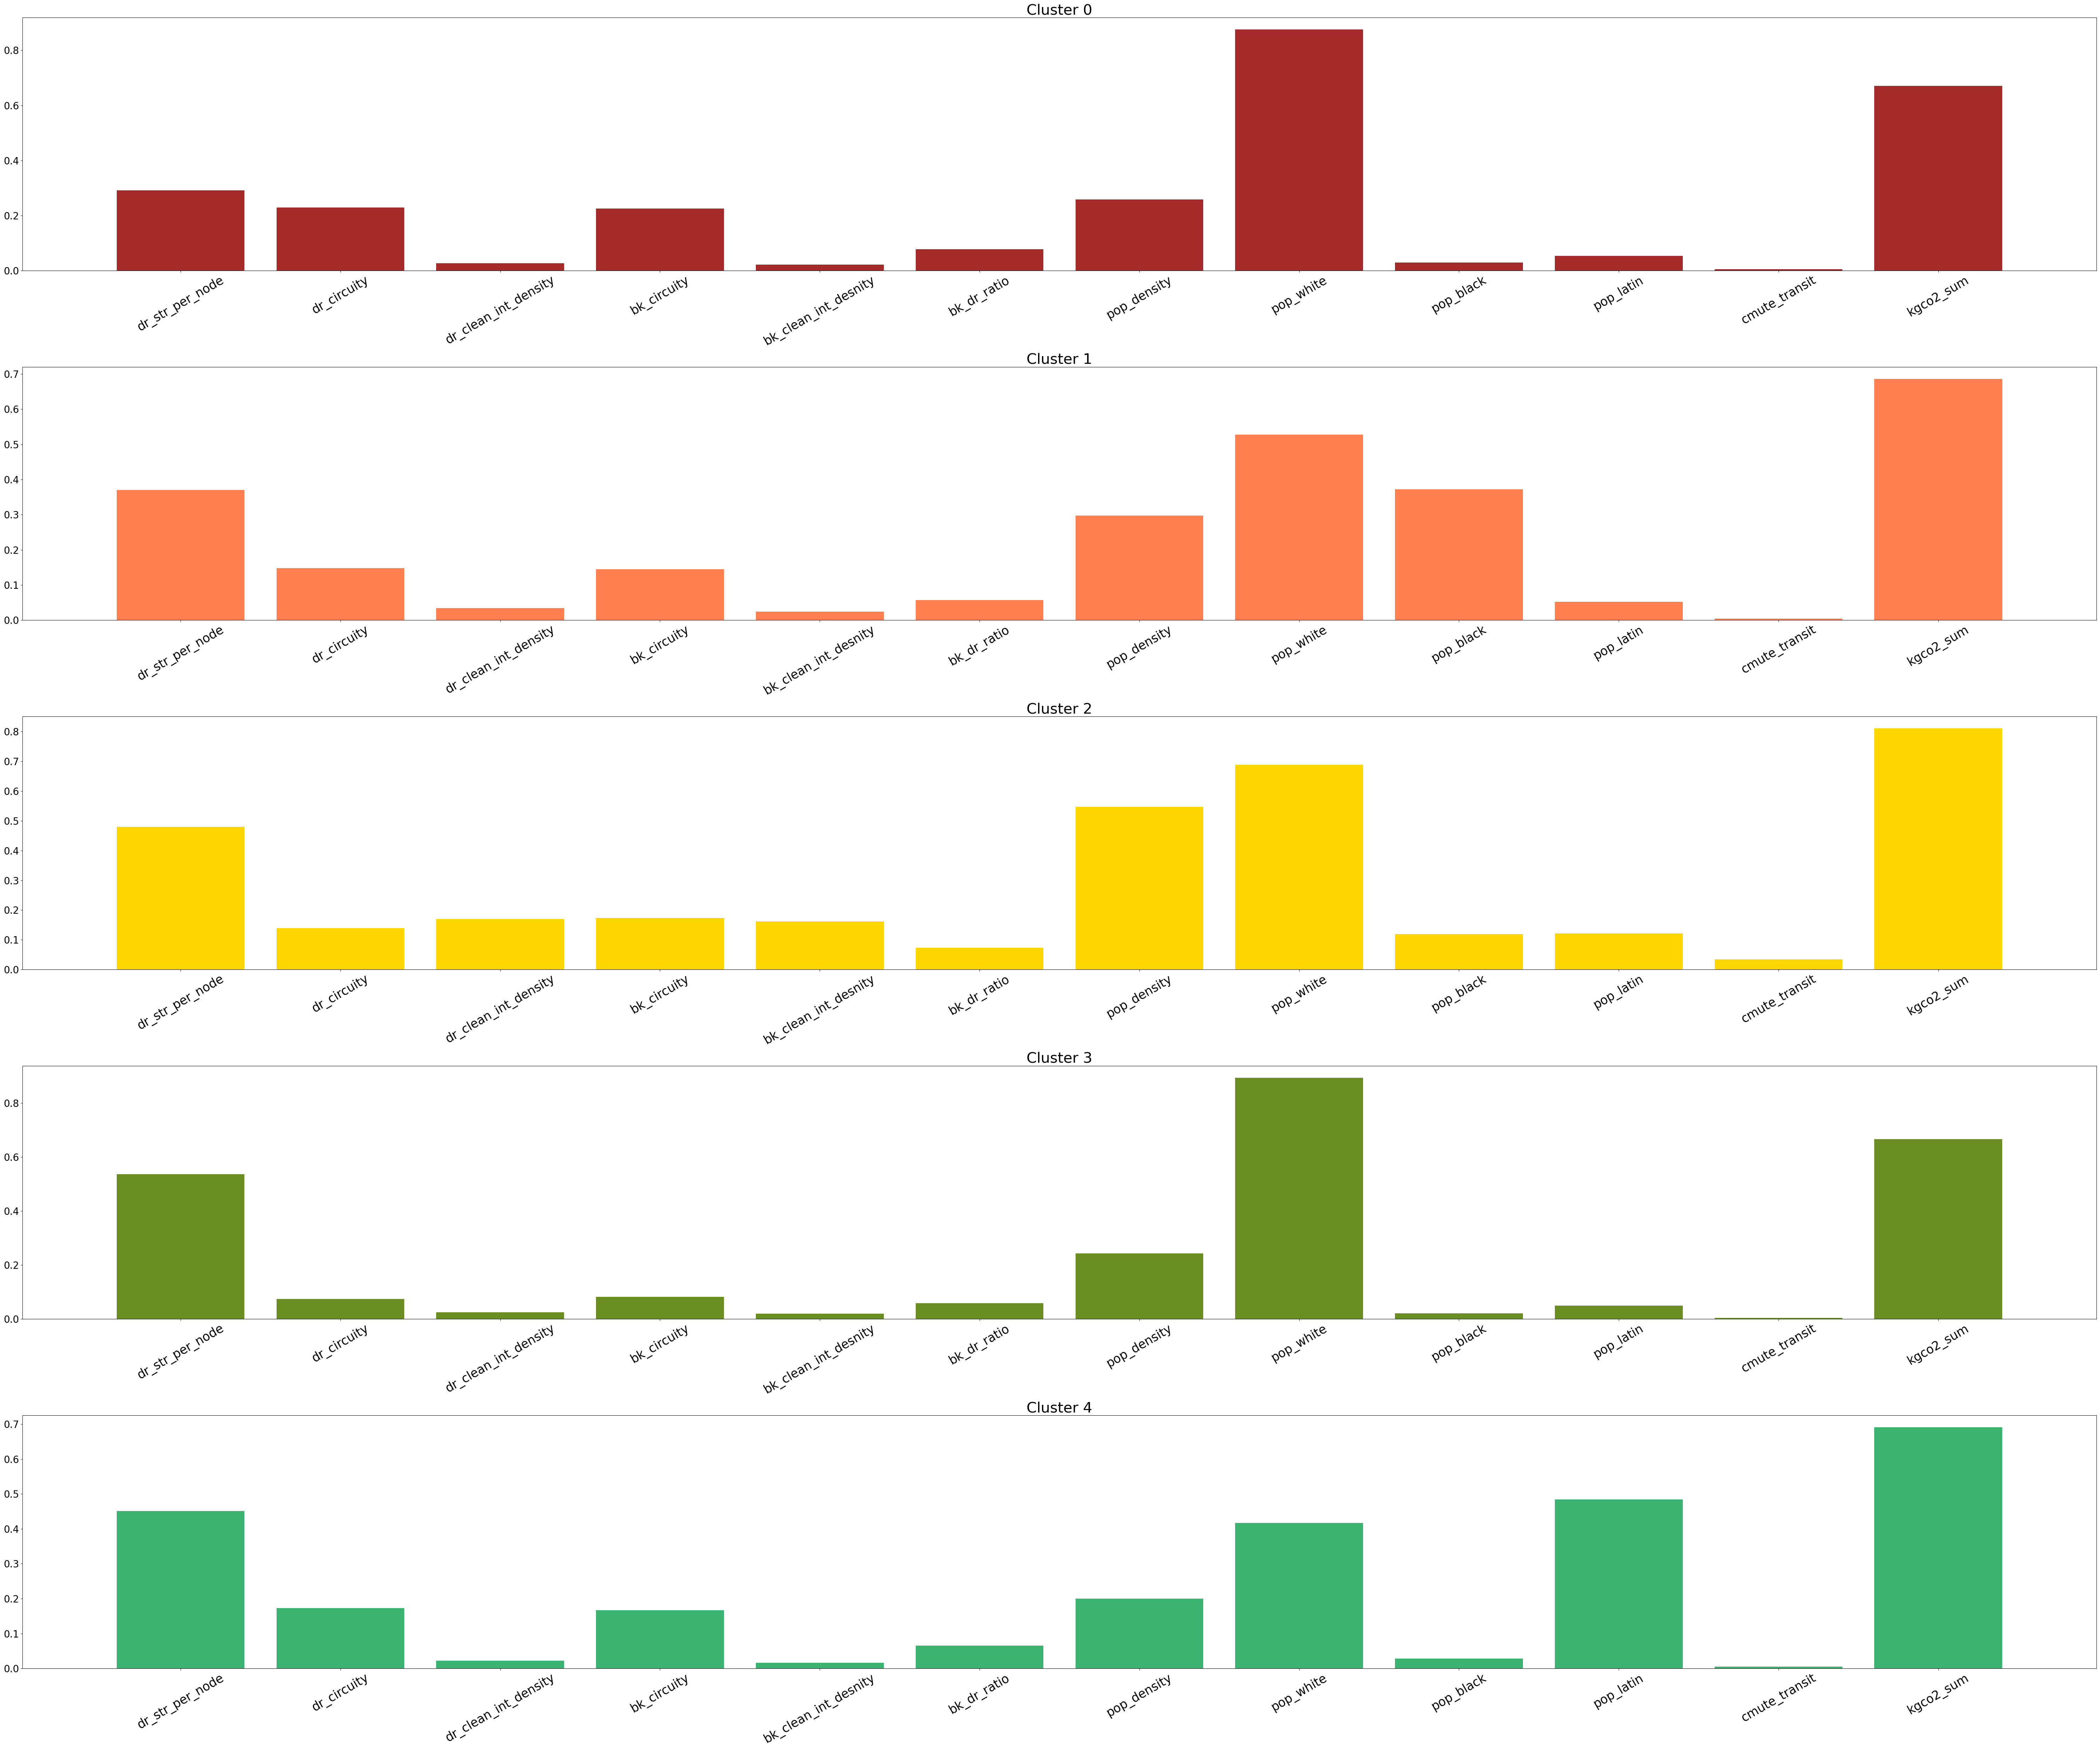

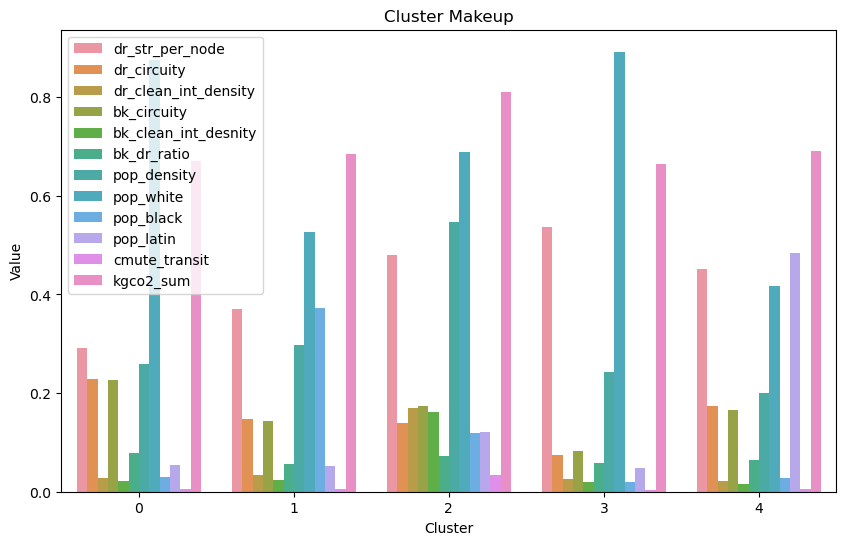

In [20]:
plot_horizontal_kmeans_bar(centroids_df_5, 5)
plot_vertical_kmeans_bar(centroids_df_5)

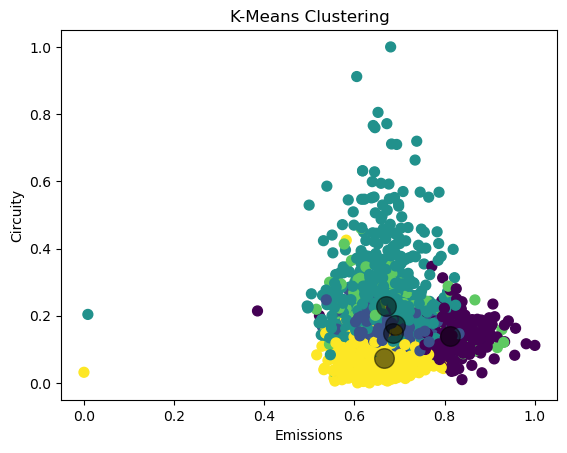

In [21]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, n_init=10)
kmeans.fit(reduced_data)
y_kmeans = kmeans.predict(reduced_data)

# Plotting the clusters
plt.scatter(reduced_data['kgco2_sum'], reduced_data['dr_circuity'], c=y_kmeans, s=50, cmap='viridis')

# Plotting the centroids of the clusters
centers = kmeans.cluster_centers_
plt.scatter(centers[:, -1], centers[:, 1], c='black', s=200, alpha=0.5)

plt.title('K-Means Clustering')
plt.xlabel('Emissions')
plt.ylabel('Circuity')
plt.show()

I am going to make one more reduction and remove the following to try to reduce it to 3 so it is comparable to our final number of archetypes

In [22]:
reduced_reduced_data = reduced_data.drop(columns=['bk_dr_ratio', 'pop_white', 'bk_circuity', 'dr_str_per_node'])
D_r_r = reduced_reduced_data.to_numpy()

# Applying KMeans
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(D_r_r)

# build DF of resulting cluster centroids
centroids_df_3 = pd.DataFrame(kmeans.cluster_centers_, columns=reduced_reduced_data.columns)

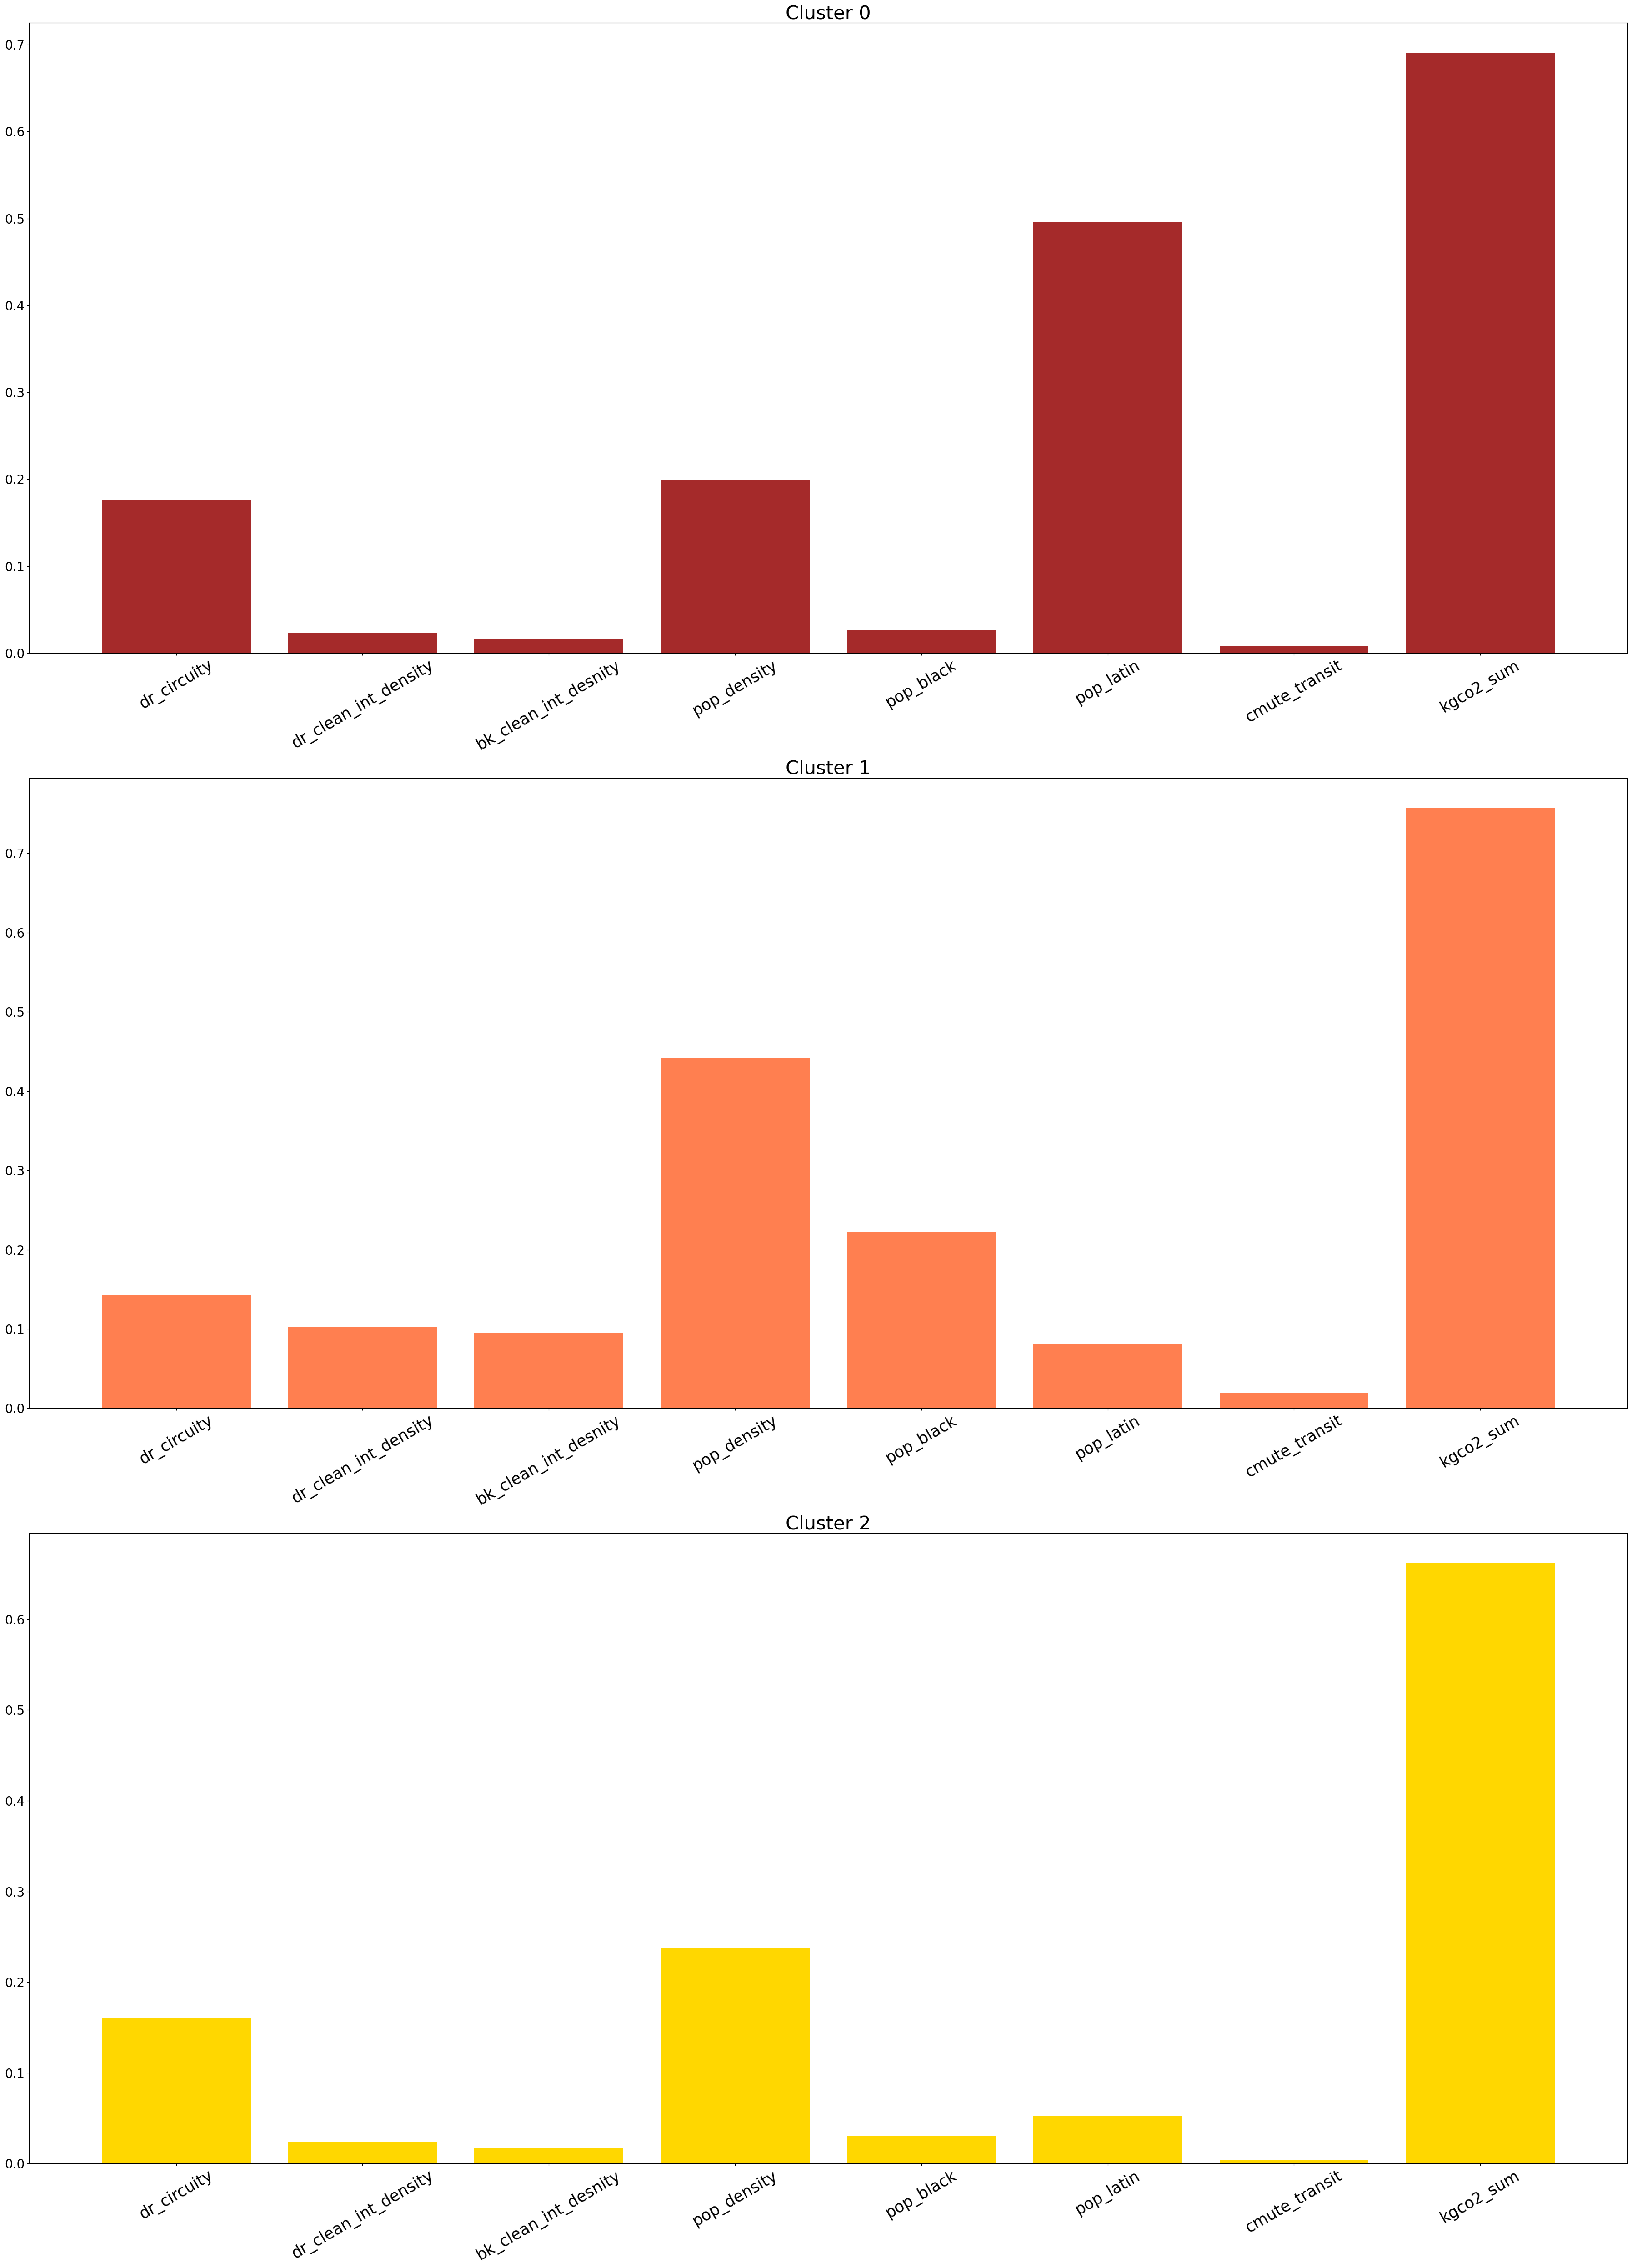

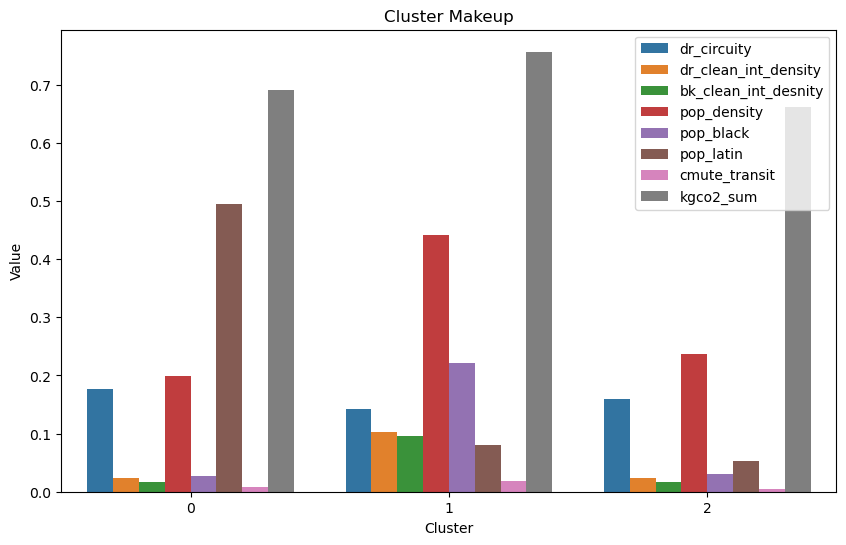

In [23]:
plot_horizontal_kmeans_bar(centroids_df_3, 3)
plot_vertical_kmeans_bar(centroids_df_3)

And alas - nothing really useful fell out in the lense of co2 emissions. Overall this method seems better for visualizing data and I think we would need to do a more careful job with dimensionality reduction and finding some more data related to transportation emissions.